In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

## Часть 1

Скачаем и преобразуем данные 

In [2]:
def dataset_prepare(df):
    df = pd.read_csv(covid_data_url)
    df.date = pd.to_datetime(df.date)
    df = df.loc[df['location'] == 'Russia']
    df = df.loc[df['date'] >= '2020-03-03']
    df.new_cases = df.new_cases.replace(0, 1)
    df = df.reset_index(drop=True)
    return df


In [3]:
covid_data_url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
cov_df = dataset_prepare(pd.read_csv(covid_data_url))

In [4]:
cov_cases_df = cov_df[["date", "total_cases", "new_cases"]]
cov_cases_df['day_ind'] = cov_cases_df.index.values
train_df = cov_cases_df.iloc[0:50]
test_df = cov_cases_df.iloc[50:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Часть 2

### Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.


Построим графики

Text(0.5, 1.0, 'Новых случаев заражения')

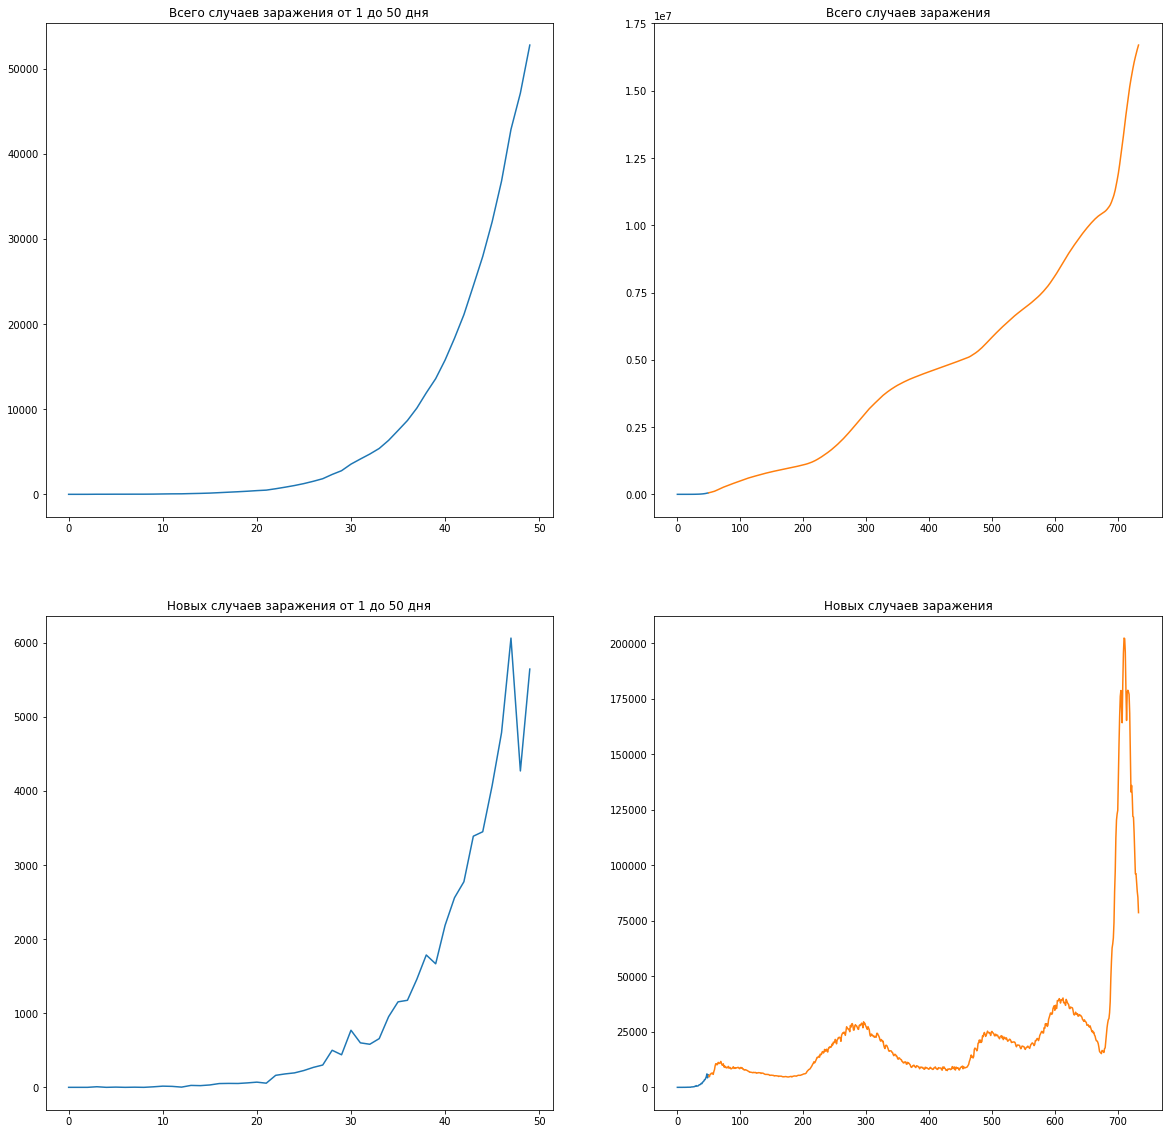

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
new_case = train_df["total_cases"]

axs[0, 0].plot(train_df["total_cases"])
axs[0, 0].set_title('Всего случаев заражения от 1 до 50 дня')

axs[0, 1].plot(train_df["total_cases"])
axs[0, 1].plot(test_df["total_cases"])
axs[0, 1].set_title('Всего случаев заражения')

axs[1, 0].plot(train_df["new_cases"])
axs[1, 0].set_title('Новых случаев заражения от 1 до 50 дня')

axs[1, 1].plot(train_df["new_cases"])
axs[1, 1].plot(test_df["new_cases"])
axs[1, 1].set_title('Новых случаев заражения')

### 2 a) Линейная регрессия 

Используя линейную регрессию, обучим модель с экспоненциальным ростом числа заболевших: train_y_l ~ exp(линейная функция от x), где train_x — номер текущего дня

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
train_y_l = np.log(train_df.total_cases.values.reshape(-1, 1))
test_y_l = np.log(test_df.total_cases.values.reshape(-1, 1))

train_x = train_df.day_ind.values.reshape(-1, 1)
test_x = test_df.day_ind.values.reshape(-1, 1)

In [8]:
reg = LinearRegression()
reg.fit(train_x, train_y_l)

LinearRegression()

In [9]:
r_sq = reg.score(train_x, train_y_l)
print('coefficient of determination:', r_sq)
print('intercept (alpha):', reg.intercept_[0])
print('slope (beta):', reg.coef_[0, 0])

coefficient of determination: 0.985339421227631
intercept (alpha): 1.820737148784695
slope (beta): 0.19829091233588567


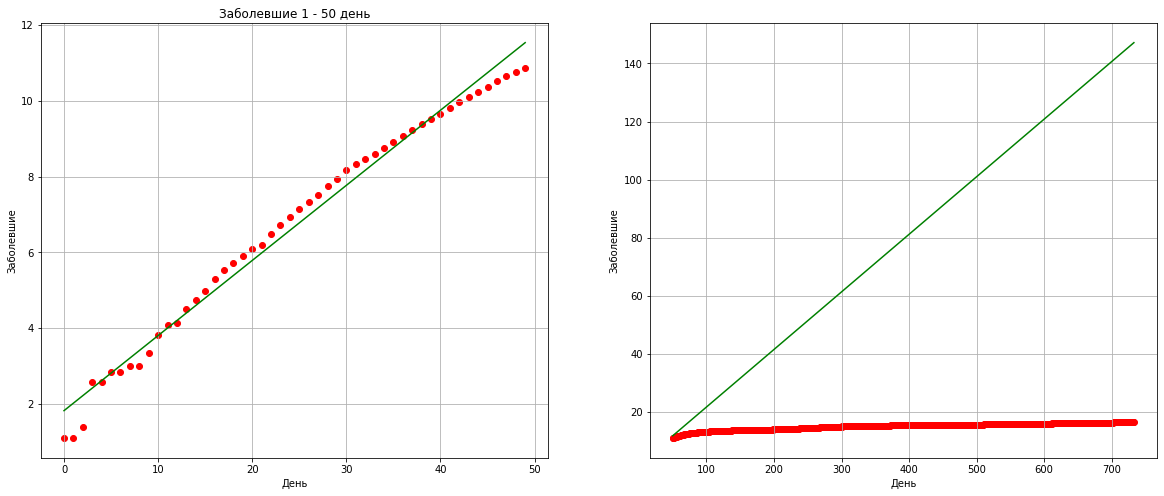

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].scatter(x = train_x, y = train_y_l, color="red" )
axs[0].plot(train_x, reg.predict(train_x), color='green')
axs[0].set(xlabel = "День", ylabel = "Заболевшие",  title = "Заболевшие 1 - 50 день" )
axs[0].grid()

axs[1].scatter(x = test_x, y = test_y_l, color="red"  )
axs[1].plot(test_x, reg.predict(test_x), color='green')
axs[1].set(xlabel = "День", ylabel = "Заболевшие")
axs[1].grid()


plt.show()

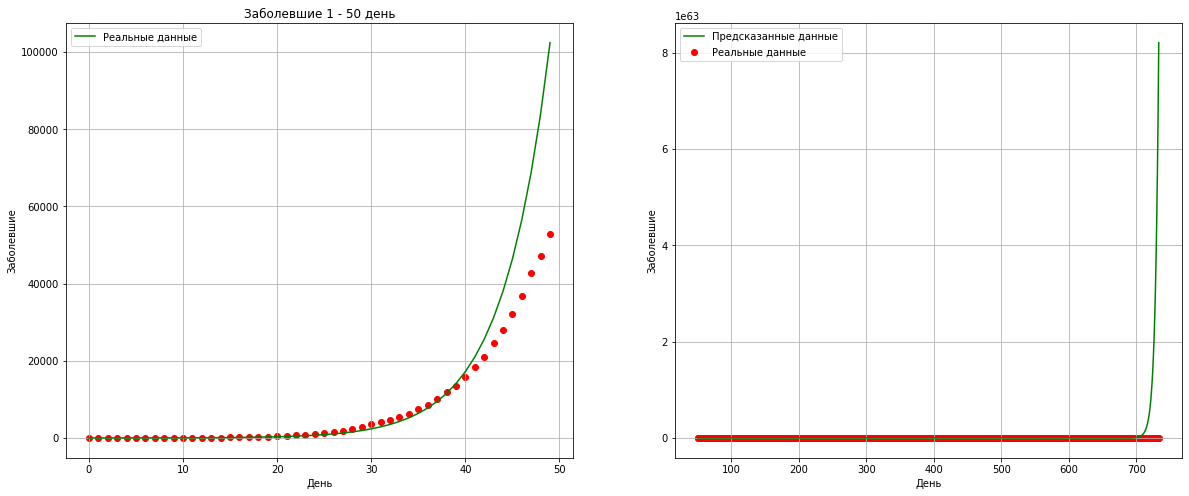

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].scatter(x = train_x, y = np.exp(train_y_l), color="red" )
axs[0].plot(train_x, np.exp(reg.predict(train_x)), color='green', label="Реальные данные")
axs[0].set(xlabel = "День", ylabel = "Заболевшие",  title = "Заболевшие 1 - 50 день", label="Реальные данные")
axs[0].legend()
axs[0].grid()

axs[1].scatter(x = test_x, y = np.exp(test_y_l), color="red", label="Реальные данные")
axs[1].plot(test_x, np.exp(reg.predict(test_x)), color='green', label="Предсказанные данные")
axs[1].set(xlabel = "День", ylabel = "Заболевшие")
axs[1].legend()
axs[1].grid()

plt.show()

Можно увидеть экспоненциальный рост

###2 b) Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [12]:
from scipy.stats import multivariate_normal

In [13]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    d_inv = (1 / (sigma_noise ** 2))
    sigma_n = np.linalg.inv(
        np.linalg.inv(sigma) + d_inv * np.transpose(x_matrix) @ x_matrix)
    mu_n = np.matmul(sigma_n, (np.linalg.inv(sigma) @ np.transpose(mu)) + (1 / (sigma_noise ** 2)) *
                     np.transpose(x_matrix) @ np.array([y]))
    return mu_n, sigma_n


def train_bayesian_update(x, y, cur_mu, cur_sigma, sigma_noise=.25):
    for i in range(x.shape[0]):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma,
                                            *x[i],
                                            *y[i],
                                            sigma_noise=sigma_noise)
    return cur_mu, cur_sigma

In [14]:
init_mu, init_sigma = np.array([0, 0]), np.eye(2) * 4
sigma_noise = (train_y_l - reg.predict(train_x)).std()

In [15]:
cur_mu, cur_sigma = train_bayesian_update(train_x, train_y_l, init_mu, init_sigma, sigma_noise)

In [16]:
N = 1000

x_lim = [1.5, 2]
y_lim = [0, 0.5]

X = np.linspace(*x_lim, N)
Y = np.linspace(*y_lim, N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)

In [17]:
print(f"Параметры модели mu: {cur_mu}")
print(f"cur_sigma: {cur_sigma}")

Параметры модели mu: [1.81645555 0.19842051]
cur_sigma: [[ 9.43743751e-03 -2.85982739e-04]
 [-2.85982739e-04  1.16798754e-05]]


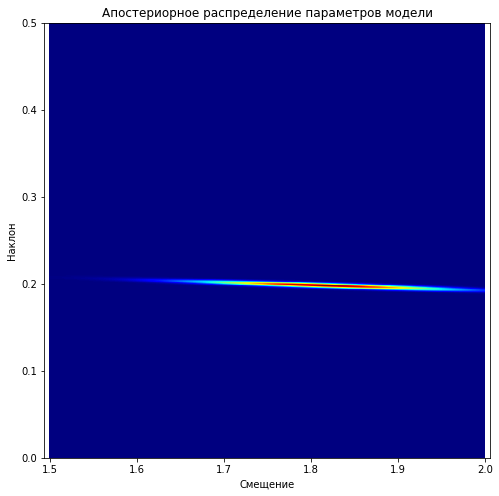

In [18]:
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

plt.figure(figsize=(8, 8))
plt.xlim(*x_lim)
plt.ylim(*y_lim)
plt.xlabel("Смещение")
plt.ylabel("Наклон")
plt.title("Апостериорное распределение параметров модели")
myplot_heatmap(Z)

### 3 c) Посэмплируем много разных экспонент, построим графики

In [19]:
start_day = pd.to_datetime("2020-03-03")
may_day = pd.to_datetime("2020-05-01")
june_day = pd.to_datetime("2020-06-01")
september_day = pd.to_datetime("2020-09-01")

num_days_may = (may_day - start_day).days
num_days_june = (june_day - start_day).days
num_days_september = (september_day - start_day).days

In [20]:
test_v = cov_cases_df.total_cases.values.reshape(-1, 1)
train_v = cov_cases_df.day_ind.values.reshape(-1, 1)


def myplot_sample_lines(mu, sigma, date, n=200, e_s=5):
    plt.figure(figsize=(15, 8))

    num_days = (date - start_day).days

    y_lim = [0, np.power(10, e_s)]
    x_lim = [0, num_days]
    xs = np.linspace(0, num_days, n)

    days = np.arange(0, num_days, 1)
    plt.plot(days, test_v[0:num_days], label='Данные', color='red')
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    dists = []
    for w in my_w:
        preds = np.exp(w[0] + w[1] * xs)

        dists.append(preds)
    dists = np.array(dists)
    plt.plot(xs, dists.T, 'k-', lw=0.4, alpha=0.2, color='dimgray')

    plt.xlim(x_lim)
    plt.ylim(y_lim)

    plt.plot(xs, dists.mean(axis=0), color='gold', linewidth=2, label="Среднее сэмплирование")

    plt.ylabel('Число случаев')
    plt.xlabel('Дни')
    plt.title(f"Сэмплирование на {date}")
    plt.legend()
    plt.show()
    return dists

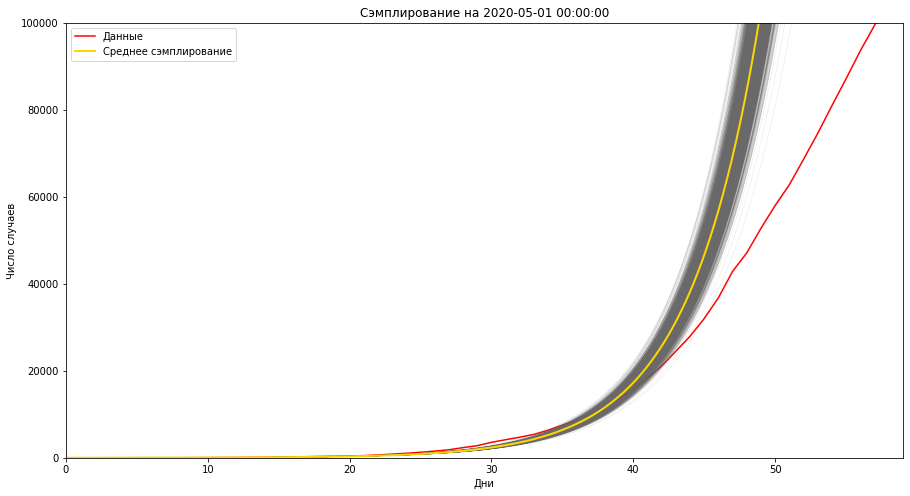

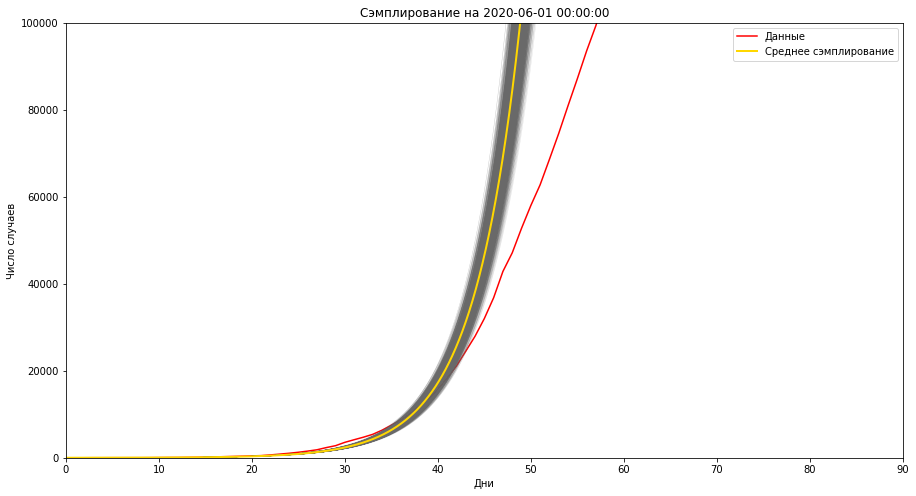

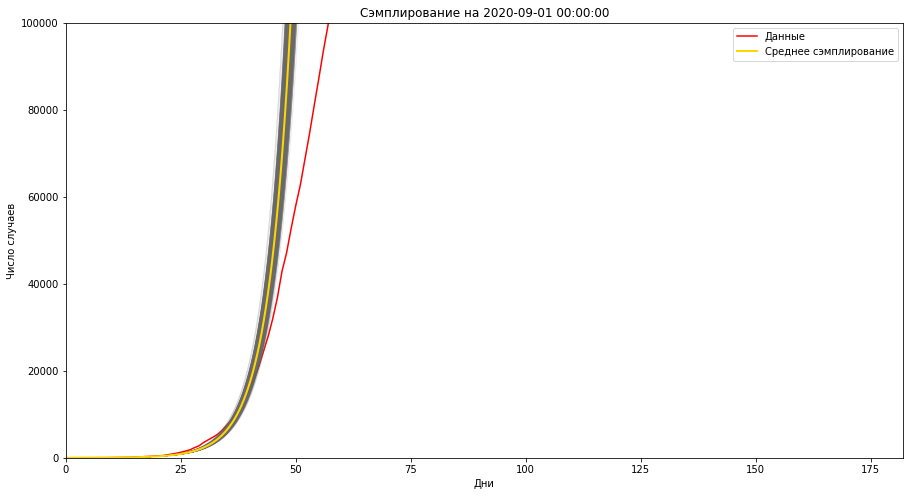

In [21]:
for i in [may_day, june_day, september_day]:
    myplot_sample_lines(cur_mu, cur_sigma, n=2000, date=i)

In [22]:
def print_histgram(date, n=10000):
    w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    num_days = (date - start_day).days
    w_val = np.exp(w[:, 0] + w[:, 1] * num_days)
    plt.figure(figsize=(8, 8))
    sns.histplot(w_val, bins=1000, kde=True, color="indigo")
    plt.ylabel('сэмплов')
    plt.xlabel('заболевших')
    plt.title(f"Заболевших к {date}")
    plt.grid(True)
    plt.show()

    print(
        f'Заболевших предсказано {w_val.mean():,.0f}, заболевших на самом деле {cov_cases_df.total_cases[num_days]:,.0f} к {date.month_name()}')
    return


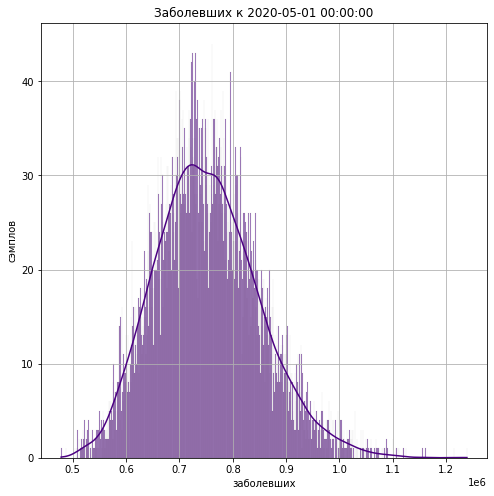

Заболевших предсказано 752,920, заболевших на самом деле 114,431 к May


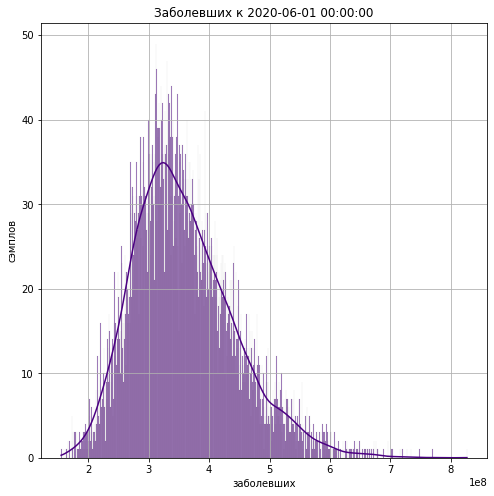

Заболевших предсказано 358,679,650, заболевших на самом деле 414,328 к June


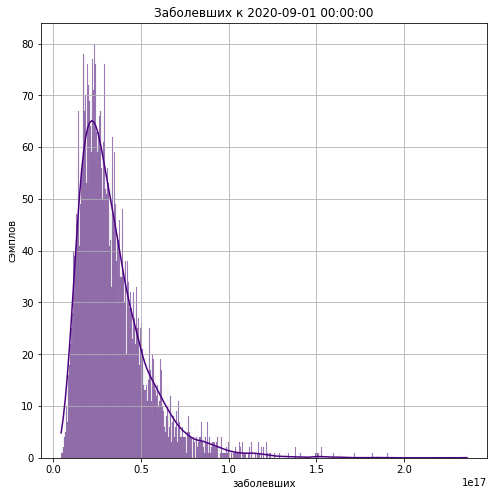

Заболевших предсказано 34,074,031,317,604,816, заболевших на самом деле 997,072 к September


In [23]:
for i in [may_day, june_day, september_day]:
    print_histgram(i)


В данной ситуации можно увидеть, что на самом деле нет экспоненциального роста заболеваемости, что исходит из многих причин исходя из чего можно сделать вывод, что вводимые ограничения имеют смысл (да и людей не так много).

##Задание 3


$$
\Phi(x)=\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x} e^{-t^{2} / 2} d t
$$
найдем производную от данной функции,
$$\frac{d(\Phi(x))}{dx} = \frac{d(\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x} e^{-t^{2} / 2} d t)}{dx}$$

учтем, что нам дано new_cases, что является производной от total_cases, $$ \frac{d(\Phi(x))}{dx} = \frac{d(totalcases)}{dx} = newcases$$


во второй части уравнения найдем производную и используем квадратичную функцию от t,
$$\frac{d(\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x} e^{\frac{-t^{2}}{ 2}} d t)}{dx} = \frac{1}{\sqrt{2 \pi}} e^{ax^{2}+bx + c}$$ 
переместим константу под экспоненту, прологарифмируем обе части уравнения.

 $$ln(newcases)=ax^{2}+bx + c$$ 
 Сделаем так

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
cov_cases_df = cov_df[["date", "total_cases", "new_cases"]]
cov_cases_df['day_ind'] = cov_cases_df.index.values
cov_cases_df["day_ind_2"] = cov_cases_df['day_ind'] ** 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
reg_sigmoid = LinearRegression()
train_sig = cov_cases_df.iloc[0:50]
test_sig = cov_cases_df.iloc[50:]

In [27]:
train_x = np.hstack((train_sig.day_ind.values.reshape(-1, 1), train_sig.day_ind_2.values.reshape(-1, 1)))
train_y = np.log(train_sig.new_cases.values.reshape(-1, 1))

test_x = np.hstack((test_sig.day_ind.values.reshape(-1, 1), test_sig.day_ind.values.reshape(-1, 1)))
test_y = np.log(test_df.new_cases.values.reshape(-1, 1))

In [28]:
reg_sigmoid = LinearRegression().fit(train_x, train_y )

In [29]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x[0], x[1]]])
    d_inv = (1 / (sigma_noise ** 2))
    sigma_n = np.linalg.inv(
        np.linalg.inv(sigma) + d_inv * np.transpose(x_matrix) @ x_matrix)

    mu_n = np.matmul(sigma_n, (np.linalg.inv(sigma) @ np.transpose(mu)) + (1 / (sigma_noise ** 2)) *
                     np.transpose(x_matrix) @ np.array([y]))
    return mu_n, sigma_n


def train_bayesian_update_3(x, y, cur_mu, cur_sigma, sigma_noise=.25):
    for i in range(x.shape[0]):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma,
                                            x[i],
                                            *y[i],
                                            sigma_noise)
    return cur_mu, cur_sigma


In [30]:
init_mu, init_sigma = np.array([0, 0, 0]), np.eye(3) * 3
sigma_noise = (train_y - reg_sigmoid.predict(train_x)).std()

In [31]:
cur_mu, cur_sigma =train_bayesian_update_3(train_x, train_y, init_mu, init_sigma)

In [32]:
print(f"Параметры модели mu: {cur_mu}")
print(f"sigma: {cur_sigma}")

Параметры модели mu: [-0.39514396  0.27550369 -0.00182777]
sigma: [[ 1.03597933e-02 -8.37005772e-04  1.40909481e-05]
 [-8.37005772e-04  9.23743685e-05 -1.76353433e-06]
 [ 1.40909481e-05 -1.76353433e-06  3.60046651e-08]]


c. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [33]:
test_v = cov_cases_df.new_cases.values.reshape(-1, 1)
train_v = np.hstack((cov_cases_df.day_ind.values.reshape(-1, 1), cov_cases_df.day_ind_2.values.reshape(-1, 1)))


def myplot_sample_lines(mu, sigma, date, n=1000, e_s=5, need_plot=True):
    plt.figure(figsize=(15, 8))

    num_days = (date - start_day).days

    days = np.arange(0, num_days, 1)

    y_lim = [0, np.power(10, e_s)]
    x_lim = [0, num_days]
    xs = np.linspace(0, num_days, n)
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    dists = []
    for w in my_w:
        preds = np.exp(w[0] + w[1] * xs + w[2] * xs ** 2)
        # plt.plot(xs, preds, 'k-', lw=0.4, alpha=0.2, color='dimgray')
        dists.append(preds)
    dists = np.array(dists)
    if need_plot:
        plt.plot(xs, dists.T, 'k-', lw=0.4, alpha=0.2, color='dimgray')

        plt.plot(days, test_v[0:num_days], label='Истинные данные', color='red')
        plt.xlim(x_lim)
        plt.ylim(y_lim)

        plt.plot(xs, (dists).mean(axis=0), color='blue', linewidth=2, label='Cреднее сэмплирование')
        plt.plot(days, np.exp(mu[0] + mu[1] * days + mu[2] * days ** 2), color='gold', label='Предсказнное моделью')

        plt.ylabel('Число новых случаев')
        plt.xlabel('дни')
        plt.title(f"Сэмплирование на {date}")
        plt.legend()
        plt.show()

    w_val = np.exp(my_w[:, 0] + my_w[:, 1] * num_days + my_w[:, 2] * num_days ** 2)

    print(
        f'Новых заболевщих предсказано {w_val.mean():,.0f}, заболевших на самом деле {test_v[num_days][0]:,.0f} к {date.month_name()}')
    return dists

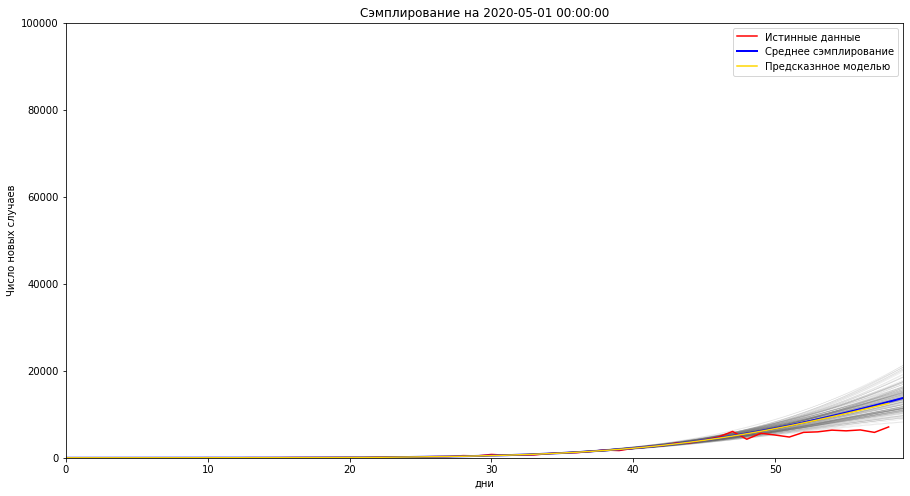

Новых заболевщих предсказано 13,736, заболевших на самом деле 7,933 к May


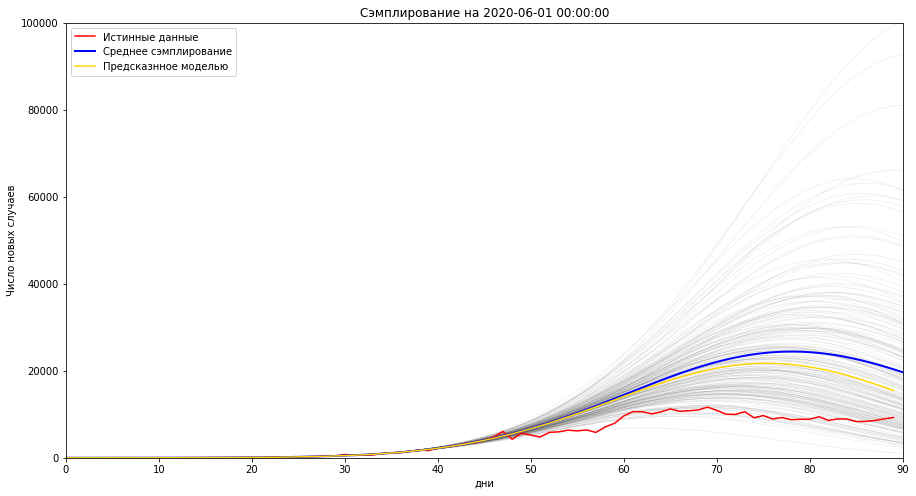

Новых заболевщих предсказано 19,669, заболевших на самом деле 8,485 к June


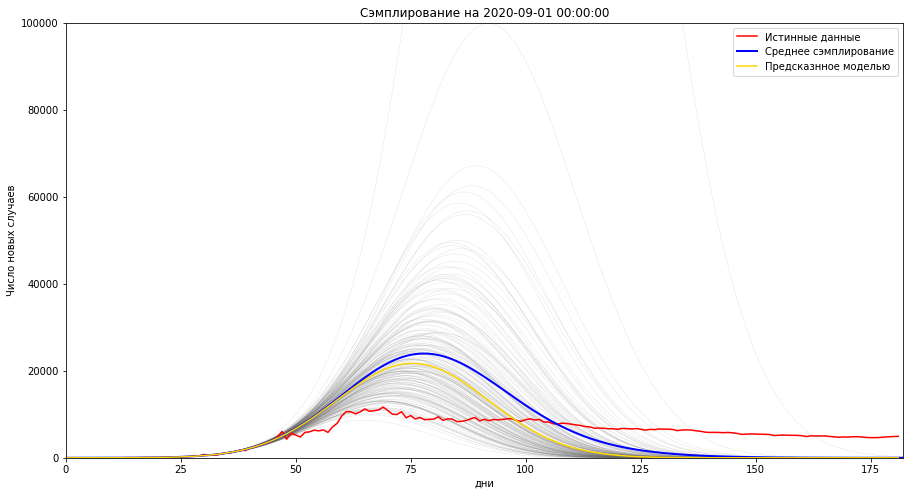

Новых заболевщих предсказано 1, заболевших на самом деле 4,670 к September


In [34]:
n_samples = 200
for i in [may_day, june_day, september_day]:
    dists = myplot_sample_lines(cur_mu, cur_sigma, n=n_samples, date=i)

In [35]:
test_v = cov_cases_df.total_cases.values.reshape(-1, 1)
train_v = np.hstack((cov_cases_df.day_ind.values.reshape(-1, 1), cov_cases_df.day_ind_2.values.reshape(-1, 1)))


def myplot_sample_lines_for_total_cases(mu, sigma, date, n=200, e_s=6, need_plot=True):
    num_days = (date - start_day).days

    days = np.arange(0, num_days, 1)

    y_lim = [0, np.power(10, e_s)]
    x_lim = [0, num_days]
    xs = np.linspace(0, num_days, n)
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    samples = []
    for w in my_w:
        preds = np.cumsum(np.exp(w[0] + w[1] * xs + w[2] * xs ** 2))
        # plt.plot(xs, preds, 'k-', lw=0.4, alpha=0.2, color='dimgray')
        samples.append(preds)
    samples = np.array(samples)
    if need_plot:
        plt.figure(figsize=(15, 8))

        plt.plot(days, test_v[0:num_days], label='Истинные данные', color='red')

        plt.plot(xs, samples.T, 'k-', lw=0.4, alpha=0.2, color='dimgray')

        plt.xlim(x_lim)
        plt.ylim(y_lim)

        plt.plot(xs, samples.T.mean(axis=1), color='blue', linewidth=2, label='Cреднее сэмплирование')
        plt.plot(days, np.cumsum(np.exp(mu[0] + mu[1] * days + mu[2] * days ** 2), axis=0), color='gold',
                 label='Предсказнное моделью')

        plt.ylabel('Число случаев')
        plt.xlabel('дни')
        plt.title(f"Сэмплирование на {date}")
        plt.legend()
        plt.show()

    return samples[:, -1]

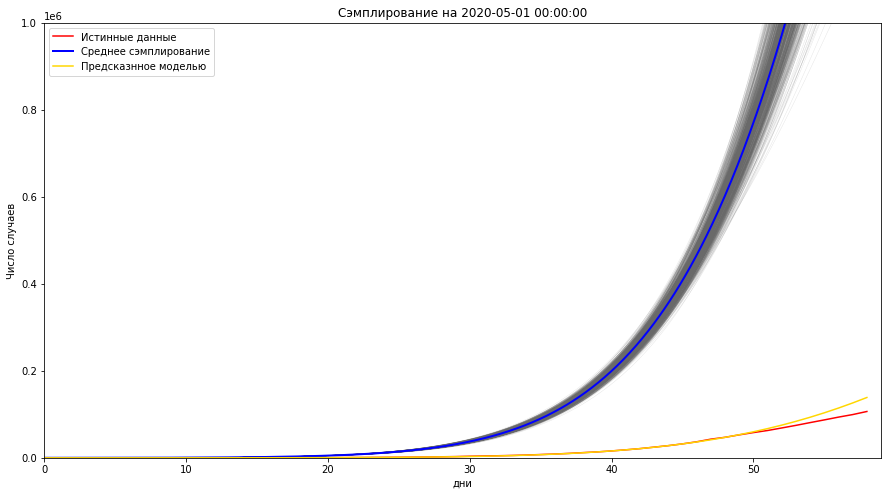

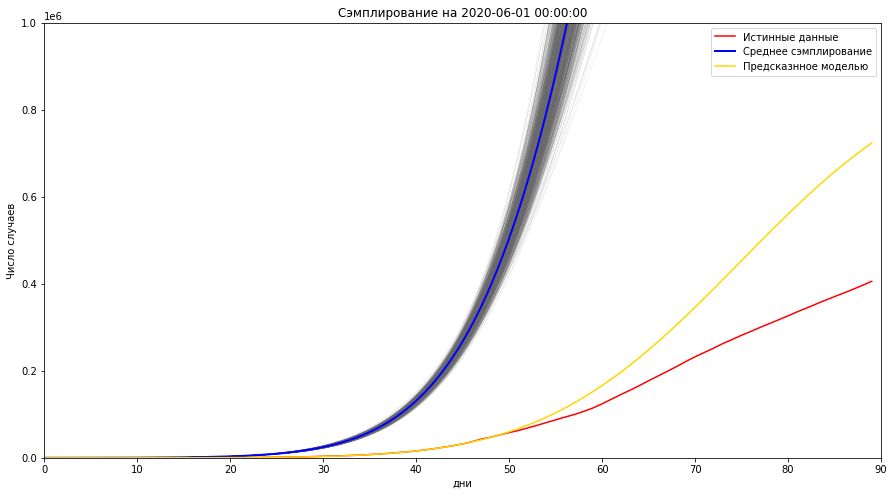

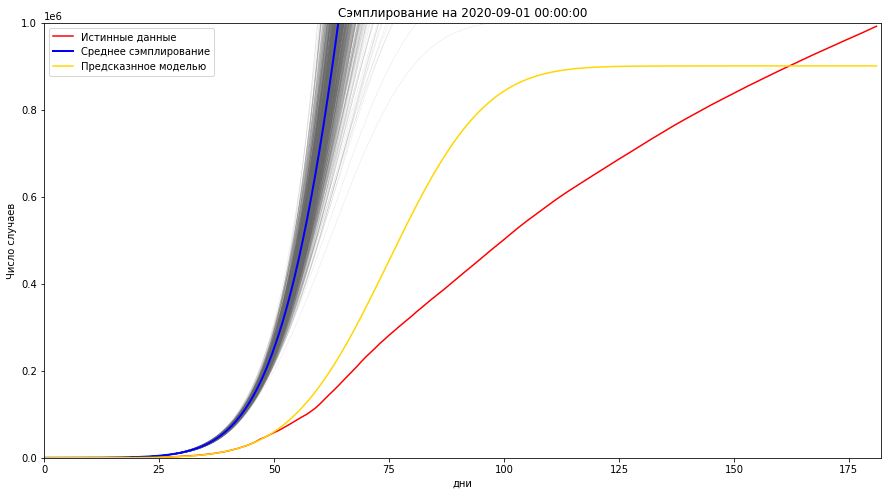

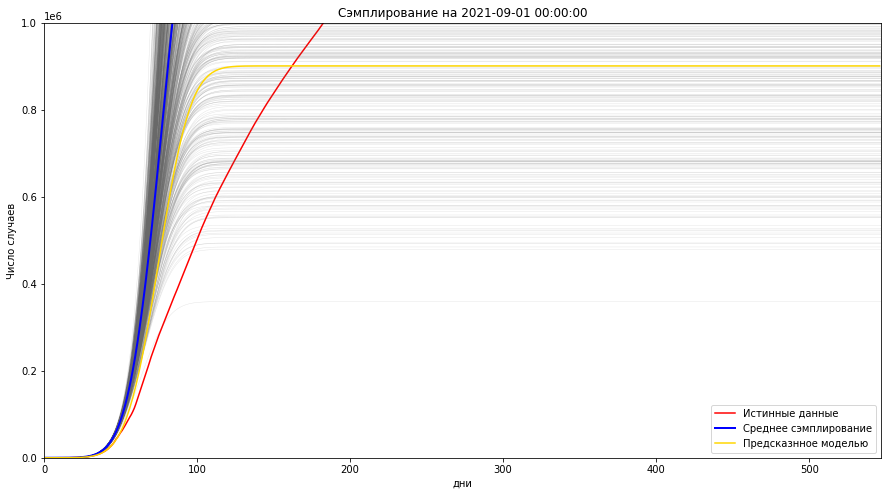

In [36]:
n_samples = 800
for i in [may_day, june_day, september_day, pd.to_datetime("2021-09-01")]:
    samples = myplot_sample_lines_for_total_cases(cur_mu, cur_sigma, n=n_samples, date=i)

In [37]:
samples_may = myplot_sample_lines_for_total_cases(cur_mu, cur_sigma, n=n_samples, date=may_day, need_plot=False)
samples_june = myplot_sample_lines_for_total_cases(cur_mu, cur_sigma, n=n_samples, date=june_day, need_plot=False)
samples_september = myplot_sample_lines_for_total_cases(cur_mu, cur_sigma, n=n_samples, date=september_day,
                                                        need_plot=False)


In [38]:
def hist_plot(data, date):
    optimistic_pred = np.quantile(data, 0.1)
    pessimistic_pred = np.quantile(data, 0.9)

    plt.figure(figsize=(9, 9))
    sns.histplot(data, bins=100, kde=True, color="indigo")
    plt.xlabel("количество заболевших")
    plt.ylabel("Число семплов")
    plt.title(f"Заболевших на  {date}")
    plt.grid(True)
    plt.show()
    print(f"на  {date}")
    print(f'10-й процентиль (оптимистическая оценка): {optimistic_pred:,.0f}')
    print(f'90-й процентиль (песимистическая оценка): {pessimistic_pred :,.0f}')

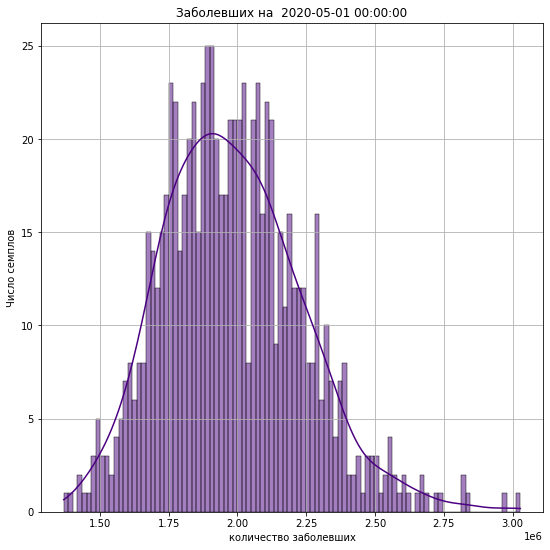

на  2020-05-01 00:00:00
10-й процентиль (оптимистическая оценка): 1,681,538
90-й процентиль (песимистическая оценка): 2,307,595


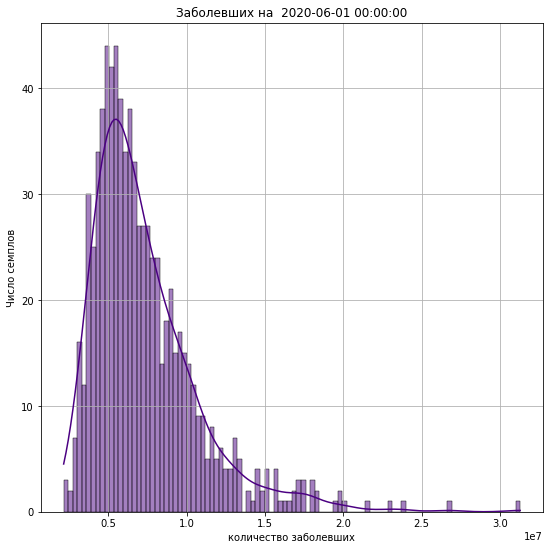

на  2020-06-01 00:00:00
10-й процентиль (оптимистическая оценка): 4,016,674
90-й процентиль (песимистическая оценка): 11,516,707


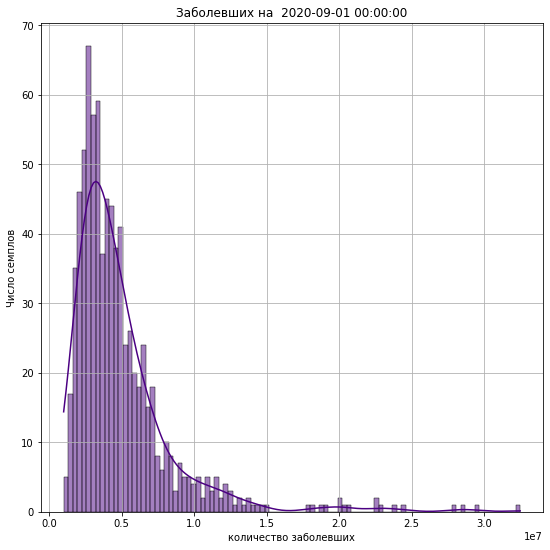

на  2020-09-01 00:00:00
10-й процентиль (оптимистическая оценка): 2,117,597
90-й процентиль (песимистическая оценка): 8,553,897


In [39]:
hist_plot(samples_may, may_day)
hist_plot(samples_june, june_day)
hist_plot(samples_september, september_day)

## Часть 4

Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

In [40]:
df = pd.read_csv(covid_data_url)
df = df[["date", 'location', "total_cases", "new_cases"]]

df.date = pd.to_datetime(df.date)
df = df.loc[df['date'] >= '2020-03-03']
df.total_cases.replace(np.NaN, 1, inplace=True)
df.new_cases.replace(np.NaN, 1, inplace=True)
df.new_cases = df.new_cases.replace(0, 1)

df = df.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [41]:
pd.options.mode.chained_assignment = None


def count_parameters(country, i):
    main_c_df = df.loc[df['location'] == country]
    main_c_df = main_c_df.reset_index(drop=True)
    main_c_df['day_ind'] = main_c_df.index.values
    main_c_df["day_ind_2"] = main_c_df['day_ind'] ** 2

    train_sig = main_c_df.iloc[i:(i + 50)]
    train_x = np.hstack((train_sig.day_ind.values.reshape(-1, 1), train_sig.day_ind_2.values.reshape(-1, 1)))
    train_y = np.log(train_sig.new_cases.values.reshape(-1, 1))

    multinational_reg = LinearRegression().fit(train_x, train_y)
    init_mu, init_sigma = np.array([0, 0, 0]), np.eye(3) * 3
    sigma_noise = (train_y - multinational_reg.predict(train_x)).std()
    cur_mu, cur_sigma = train_bayesian_update_3(train_x, train_y, init_mu, init_sigma)
    return cur_mu, cur_sigma


def find_that_day(df):
    countries = sorted(df.location.unique())
    contries_start_stat_day = dict.fromkeys(countries, 0)
    for country in countries:
        arr = np.array(df.loc[df['location'] == country].total_cases)
        pred = arr[0]
        for i, val in enumerate(arr):
            if val <= pred:
                continue
            else:
                contries_start_stat_day[country] = count_parameters(country, i)
                break
        if contries_start_stat_day[country] == 0 or arr[-1] < 10e6:
            del contries_start_stat_day[country]
    return contries_start_stat_day


In [42]:
multy_param = find_that_day(df)
for_delete = ['Africa', 'Asia', 'Europe', 'European Union', 'High income', 'South America', 'Upper middle income',
              'World', "North America"]
multy_param = dict([(key, val) for key, val in
                    multy_param.items() if key not in for_delete])


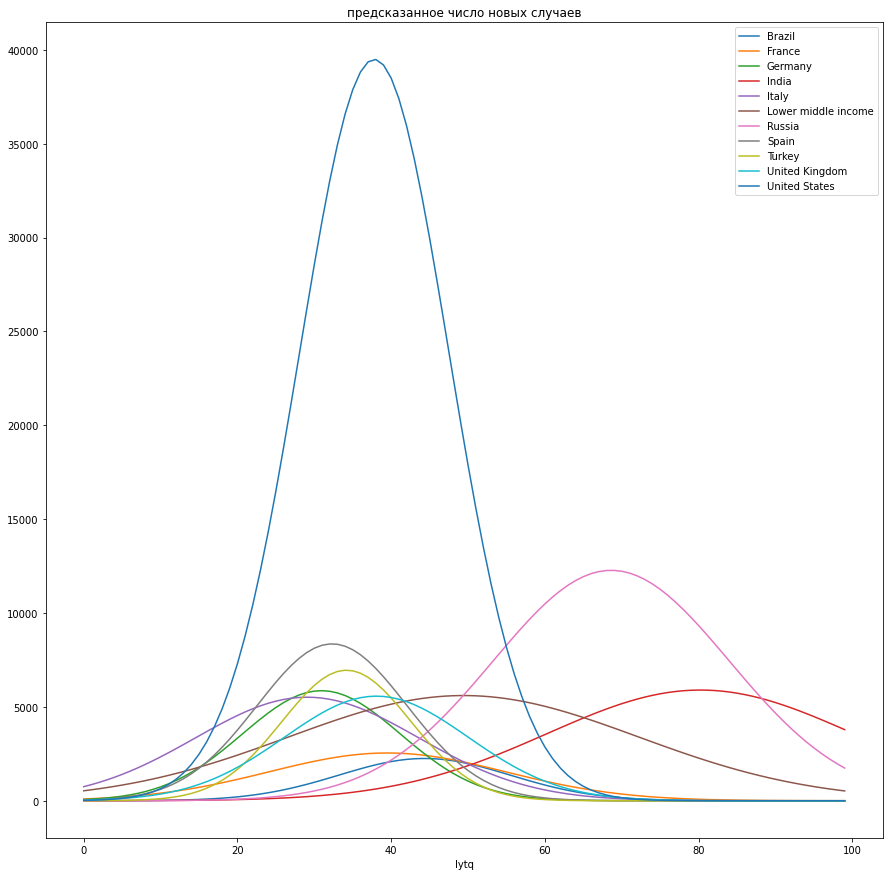

In [43]:
plt.figure(figsize=(15, 15))

n = 100
num_days = (june_day - start_day).days

days = np.arange(0, num_days, 1)

xs = np.arange(0, 100)

samples = []
for key, value in multy_param.items():
    w = value[0]
    # preds = np.cumsum(np.exp(w[0] + w[1] * xs + w[2] * xs ** 2))
    plt.plot(xs, np.exp(w[0] + w[1] * xs + w[2] * xs ** 2), label=key)
plt.legend()
plt.xlabel("lytq")
plt.title('предсказанное число новых случаев')
plt.show()


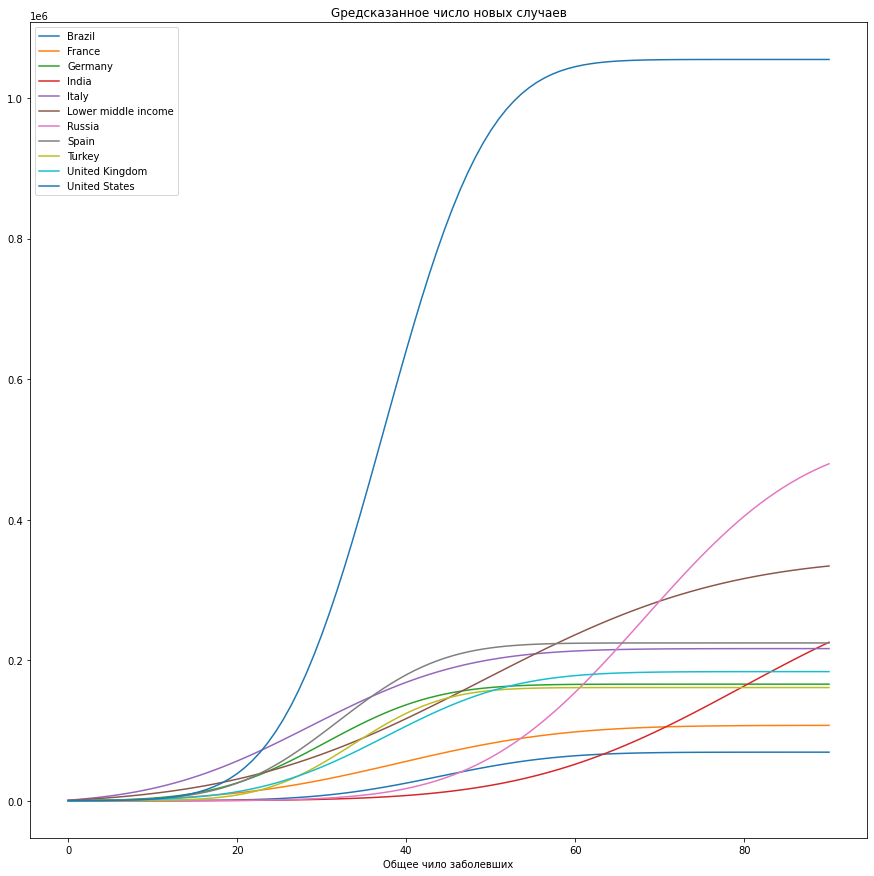

In [44]:
plt.figure(figsize=(15, 15))

n = 100
num_days = (june_day - start_day).days

days = np.arange(0, num_days, 1)

xs = np.linspace(0, num_days, n)

for key, value in multy_param.items():
    w = value[0]
    # preds = np.cumsum(np.exp(w[0] + w[1] * xs + w[2] * xs ** 2))
    plt.plot(xs, np.cumsum(np.exp(w[0] + w[1] * xs + w[2] * xs ** 2)), label=key)
plt.legend()
plt.xlabel("Дней")
plt.xlabel("Общее чило заболевших")
plt.title('Gредсказанное число новых случаев')
plt.show()


Можно сделать вывод, что развитие болезни в странах проиcходит по похожему сценарию и следовательно меры борьбы с вирусом для стран должны быть примерно идентичными.

## Часть 5

Введение карантина в различных странах связанно, как с увеличением скорости заболеваемости, так и готовности коечного фонда и состоянием здравоохранения, политическими процессами в самой стране и множеством иных процессов (воздействие карантина на экономику, средний возраст населения, уровень развития медицины и тд.)


Основная цель введения карантина сдерживание экспоненциального роста заболеваемости, до того объёма, который может принять коечный фонд, а также сдерживать заболеваемость для проведения исследований и появления вакцины, что нацелено на создание коллективного иммунитета. Следует учесть, что при крайне строгом карантине, когда число новых заболевших снижается слишком быстро, что может повлечь за собой появление новых волн вируса из-за мутации вируса (и сезонности заболеваний) при отсутствии иммунитета у людей (т.к. переболевшие и привитые люди становятся носителями иммунитета и имеют более низкий шанс заразиться и заразить других (а при повторном заражение течение болезни происходит в более легкой форме)).


Так решение нужно ли вводить карантин должно исходить:
1. Наличием коечного фонда.
2. Введение карантина и его строгости в зависимости от скорости роста заболеваемости, для того чтобы не создавать критическую нагрузку на здравоохранение
3. Поддержка числа новых случаев в определенном диапазоне для равномерной нагрузки на здравоохранение с целью создания коллективного иммунитета (параллельно проводя вакцинацию для поддержки коллективного иммунитета) (вирусы со временем при адаптации к человеку становятся менее агрессивны, и летальны). В какой-то момент штаммы станут более легко переносимыми и ковид станет, как вирус гриппа, что может занять не один год.

Все это можно увидеть по числу новых случаев, где оно сначало растет а затем выходит на один уровень (происходит своего рода насыщение).

Нельзя сделать крайне строгий карантин и ввести вакцину всем, не рассчитывая на переболевших т.к. вакцинированные люди все равно заболеют новыми мутировавшими штаммоми (которые могут распространятся параллельно хоть и с меньшим риском летальности) для предотвращения чего нужно оперативно перевакцинироваться, что крайне затруднительно. И все равно люди будут болеть. 

И очевидно нельзя не вводить карантин, особенно в развитых странах с большим числом пожилых людей, это очевидным образом создаст критическую нагрузку на здравоохранение приведет к избыточной смертности.